# fMRI project

## 0. import modules

In [1]:
import scipy.io as sio
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from scipy.stats.stats import pearsonr as ps
import math
import matplotlib.pyplot as plt

## 1. Load and store data

In [2]:
# load data
nP = 8
nTrial = 360
nWord = 60
nRep = 6
nFeature = 25
xVoxels = 51
yVoxels = 61
zVoxels = 23

whichLayer = 9

contents = []
data = []
info = []
meta = []
layerIndex = []

for i in range(nP):
    contents.append(sio.loadmat('./fMRI_data/data-science-P'+str(i+1)+'.mat'))
    data.append(contents[i]['data'])
    info.append(contents[i]['info'])
    meta.append(contents[i]['meta'])
    layerIndex.append(meta[i][0][0][8][:,:,whichLayer])

## 2. Load the feature matrix as X

In [3]:
X = np.array(pd.read_excel('./fMRI_data/features4.xls'))
X = X.T
X = X * np.divide(1, np.linalg.norm(X, axis = 1))[:, np.newaxis]

## 3. Set a list storing the indexs for each word and their respective class

In [4]:
words = ['airplane', 'ant', 'apartment', 'arch', 'arm', 'barn', 'bear', 'bed', 'bee', 'beetle', \
         'bell', 'bicycle', 'bottle', 'butterfly', 'car', 'carrot', 'cat', 'celery', 'chair', \
         'chimney', 'chisel', 'church', 'closet', 'coat', 'corn', 'cow', 'cup', 'desk', 'dog', \
         'door', 'dress', 'dresser', 'eye', 'fly', 'foot', 'glass', 'hammer', 'hand', 'horse', \
         'house', 'igloo', 'key', 'knife', 'leg', 'lettuce', 'pants', 'pliers', 'refrigerator', \
         'saw', 'screwdriver', 'shirt', 'skirt', 'spoon', 'table', 'telephone', 'tomato', \
         'train', 'truck', 'watch', 'window']

# Classify same words and their class
word_index = [[] for k in range(nWord)]
word_class = [[] for k in range(nWord)]
for word in words:
        for j in range(nTrial):
            if info[0][0][j][2][0] == word:
                word_index[words.index(word)].append(j)
                word_class[words.index(word)].append(info[0][0][j][0][0])
classAss = np.array(word_class)[:,0]

## 4. Visualize brain layers from data

In [29]:
images = []
for i in range(nP):
    img = np.zeros((nWord, xVoxels, yVoxels))
    for k in range(nWord):
        for m in range(nRep):
            
            for x in range(xVoxels):
                for y in range(yVoxels):
                    if layerIndex[i][x,y] > 0:
                        img[k][x][y] += data[i][word_index[k][m]][0][0][layerIndex[i][x,y]-1]
                    else:
                        img[k][x][y] -=5
        img[k] /= nRep
    images.append(img)

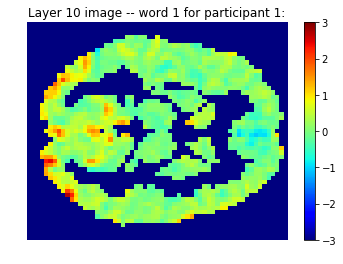

In [35]:
word = 0
person = 0
fig, ax = plt.subplots()
plt.imshow(images[person][word], cmap = plt.cm.jet, interpolation='none')
plt.colorbar()
plt.axis('off')
plt.title('Layer %d image -- word %d for participant %d:' % (whichLayer+1, word+1, person+1))
plt.clim(-3,3)
plt.show()

## 5. Training with bootstrap

In [46]:
from multiprocessing import Pool
import os
import pickle

In [47]:
def bootstrap(X, Y, count, count2, inds):
    Y_ps=[]
    corr_mat = np.zeros((nWord, nWord))
    for k in range(0,nWord-1):
        for kk in range(k+1, nWord):
            ind = inds[count2]
            ind = np.array([[int(ele) for ele in ind]])
            X_tr = np.concatenate((X[0:k],X[k+1:kk],X[kk+1:]), axis = 0)
            Y_tr = np.concatenate((Y[0:k],Y[k+1:kk],Y[kk+1:]), axis = 0)

            mu_x = np.mean(X_tr, axis = 0)
            mu_y = np.mean(Y_tr, axis = 0)

            X_tr -= mu_x
            Y_tr -= mu_y
            X_va = X[[k, kk]] - mu_x
            Y_va = Y[[k, kk]] - mu_y
            W = np.linalg.solve(X_tr.T@X_tr + lamb*np.eye(nFeature), X_tr.T@Y_tr)
            
            Y_pred = X_va@W
            
            # calculate the cos-similarities
            coss11 = cosine_similarity(Y_pred[0][ind].reshape(1,-1), Y_va[0][ind].reshape(1,-1))
            coss22 = cosine_similarity(Y_pred[1][ind].reshape(1,-1), Y_va[1][ind].reshape(1,-1))
            coss12 = cosine_similarity(Y_pred[0][ind].reshape(1,-1), Y_va[1][ind].reshape(1,-1))
            coss21 = cosine_similarity(Y_pred[1][ind].reshape(1,-1), Y_va[0][ind].reshape(1,-1))
            
            # calculate the matches for comparing
            match1122 = coss11 + coss22
            match1221 = coss12 + coss21

            if match1122 > match1221: count += 1    
            count2 += 1
            
            corr_mat[k][k] = coss11
            corr_mat[kk][kk] = coss22
            corr_mat[k][kk] = coss12
            corr_mat[kk][k] = coss21
            
        Y_ps.append(Y_pred[0])
    return Y_ps, count, count2, corr_mat

In [48]:
def compute(i):
    nVoxel = len(data[i][0][0][0])
    Y = np.zeros((nWord, nVoxel)) # 60 images for training
    count = 0
    # Average same words
    for k in range(nWord):
        for m in range(nRep):
            Y[k] += data[i][word_index[k][m]][0][0]
        Y[k] /= nRep

    count2 = 0
    # select 500 voxels which perform best
    inds = np.array(pd.read_csv('./fMRI_data/ind'+str(i+1)+'.txt', header=None))
    
    # Begin bootstrap
    Y_ps, count, count2, corr_mat = bootstrap(X, Y, count, count2, inds)  
    pickle.dump(Y_ps,open('Y_ps_'+str(i+1)+'.txt', 'wb'))
    
    # write corr_mat into file
    pickle.dump(corr_mat,open('corr_mat_'+str(i+1)+'.txt', 'wb') ) 
    print(i, count/count2)

In [ ]:
lamb = 1.5
Y_preds = []

print('Parent process %s.' % os.getpid())

p = Pool(8)
for i in range(8):  
    p.apply_async(compute, args=(i,))
p.close()
p.join()

print('All subprocesses done.')

Parent process 8710.
6 0.7531073446327684
7 0.6519774011299435
3 0.7853107344632768
5 0.6440677966101694
4 0.7779661016949152
0 0.8259887005649718
2 0.7559322033898305


## 6. Change Y$_{\text{pred}}$ to images

In [36]:
Y_preds = []
images = []

for i in range(nP):
    Y_preds.append(pickle.load(open('Y_ps_'+str(i+1)+'.txt', 'rb')))
    img = np.zeros((nWord, xVoxels, yVoxels))
    for k in range(nWord-1):
        for m in range(nRep):
            
            for x in range(xVoxels):
                for y in range(yVoxels):
                    if layerIndex[i][x,y] > 0:
                        img[k][x][y] += Y_preds[i][k][layerIndex[i][x,y]-1]
                    else:
                        img[k][x][y] -=5
        img[k] /= nRep
    images.append(img)

## 7. Plot the predicted image

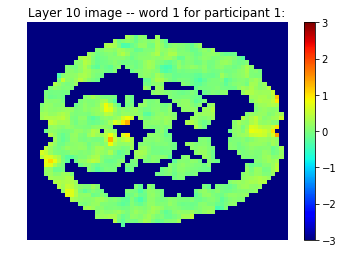

In [37]:
word = 0
person = 0

fig, ax = plt.subplots()
plt.imshow(images[person][word], cmap = plt.cm.jet, interpolation='none')
plt.colorbar()
plt.axis('off')
plt.clim(-3,3)
plt.title('Layer %d image -- word %d for participant %d:' % (whichLayer+1, word+1, person+1))
plt.show()

## 8. Build and plot the correlation matrix¶

In [39]:
corr_mats = []
for i in range(nP):
    corr_mats.append(pickle.load(open('corr_mat_'+str(i+1)+'.txt', 'rb')))

In [40]:
nCond = 12
cond_index = [[] for k in range(nCond)]
conds = ['animal', 'bodypart', 'building', 'buildpart', 'clothing', 'furniture', 'insect'\
         , 'kitchen', 'manmade', 'tool', 'vegetable', 'vehicle']
for cond in conds:
    for j in range(nWord):
        if info[0][0][j][0][0] == cond:
            cond_index[conds.index(cond)].append(j)

In [41]:
axis = list(np.array(cond_index).reshape(nWord,))

In [42]:
new_mats = np.zeros((nP, nWord, nWord))
for i in range(nP):
    for x in range(nWord):
        for y in range(nWord):
            new_mats[i][x][y] = corr_mats[i][axis[x]][axis[y]]

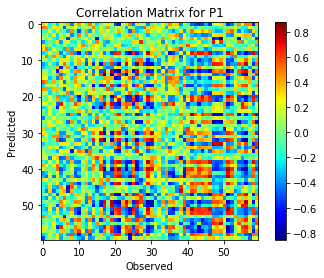

In [45]:
p = 0
plt.figure()
plt.imshow(new_mats[p], cmap = plt.cm.jet, interpolation='none')
plt.colorbar()
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Correlation Matrix for P%d' % (p+1))
plt.show()

In [33]:
avg_mat = np.sum(new_mats, axis=0)/nP

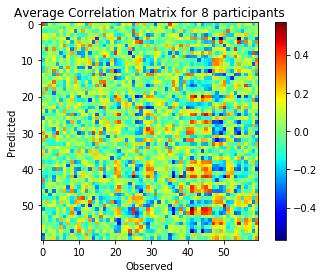

In [34]:
plt.figure()
plt.imshow(avg_mat, cmap = plt.cm.jet, interpolation='none')
plt.colorbar()
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Average Correlation Matrix for %d participants' % (nP))
plt.show()

## 9. Calculate the diagonal mean and total mean

In [35]:
for p in range(nP):
    print('For P%d, the total mean is %.3f, the mean of diagonal elements is %.3f' % \
    (p+1, np.mean(new_mats[p]), np.mean(np.diagonal(new_mats[p]))))

avg_total_mean = 0
avg_diag_mean = 0
for p in range(nP):
    avg_total_mean += np.mean(new_mats[p])/nP
    avg_diag_mean += np.mean(np.diagonal(new_mats[p]))/nP
    
print('Averagely, the total mean is %.3f, the mean of diagonal elements is %.3f' % \
    (avg_total_mean, avg_diag_mean))

For P1, the total mean is 0.010, the mean of diagonal elements is 0.335
For P2, the total mean is 0.007, the mean of diagonal elements is 0.258
For P3, the total mean is 0.006, the mean of diagonal elements is 0.209
For P4, the total mean is 0.005, the mean of diagonal elements is 0.163
For P5, the total mean is 0.004, the mean of diagonal elements is 0.154
For P6, the total mean is 0.005, the mean of diagonal elements is 0.110
For P7, the total mean is 0.003, the mean of diagonal elements is 0.188
For P8, the total mean is 0.002, the mean of diagonal elements is 0.059
Averagely, the total mean is 0.005, the mean of diagonal elements is 0.184


## (** Ridge Plot)

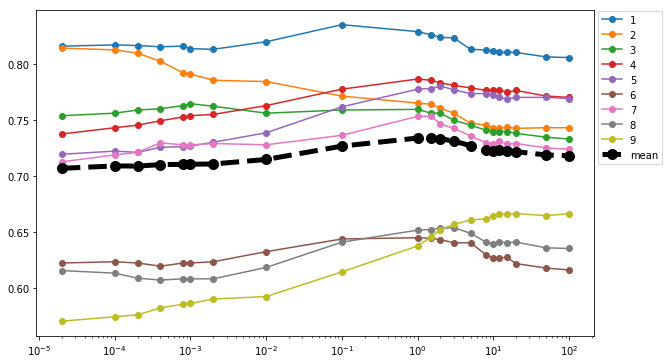

In [125]:
plt.figure(figsize=(10, 6))
for i in range(len(accuracies)):
    plt.plot(lambs[0:21],accuracies[i][0:21],'o-', label = '%d' % (i+1))
plt.plot(lambs[0:21],np.mean(accuracies,axis=0)[0:21],'ko--',linewidth=5, markersize = 10, label = 'mean')
plt.xscale('log')
plt.legend(loc='upper right', bbox_to_anchor=(0.13, 0.91, 1., .102))
plt.show()

## 10. Prediction with noises in fMRI images of the 1st subject

In [11]:
ind_Total=[]
for i in range(nP):
    ind = np.array(pd.read_csv('./ind'+str(i+1)+'.txt', header = None))
    ind_Total.append(ind)

In [193]:
# length of the fMRI images of the first subject
sb = 0
nVoxel = len(data[sb][0][0][0])

insula_coord = list(pd.read_excel('./insula_coord/insula_coord_'+str(sb+1)+'.xls'))

Y = np.zeros((nWord, nVoxel))
# Average same words and add noises to some certain region of the brain
for k in range(nWord):
    for m in range(nRep):
        Y[k] += data[sb][word_index[k][m]][0][0]
    Y[k] /= nRep
Ymean = np.mean(Y,axis=0)
Y-= Ymean

In [12]:
match_clean = []

for k in range(60):
    
    X_tr = np.concatenate((X[0:k],X[k+1:]), axis = 0)            
    Y_tr = np.concatenate((Y[0:k],Y[k+1:]), axis = 0)
            
    Xmean = np.mean(X_tr,axis=0)
    Ymean = np.mean(Y_tr,axis=0)
    # X_tr -= Xmean
    Y_tr -= Ymean
            
    X_va = X[k].reshape(1,nFeature)
    Y_va = Y[k].reshape(1,nVoxel) - Ymean
            
    W = np.linalg.solve(X_tr.T@X_tr, X_tr.T@Y_tr)    
    # W = np.linalg.solve(X_tr.T@X_tr + lamb*np.eye(nFeature), X_tr.T@Y_tr)
    Y_pred = X_va@W

    ind = ind_Total[0].astype(int)
    match_clean.append(cosine_similarity(Y_pred[0][ind].reshape(1,-1), Y_va[0][ind].reshape(1,-1))[0][0])

In [31]:
epoch = 100
match_noise = np.zeros(nWord)

# take the statistical average of the random noises
for i in range(epoch):
    
    Y_noise = np.copy(Y)
    for k in range(nWord):
        Y_noise[k][insula_coord] = 3*np.random.randn(len(insula_coord))    
    
    for k in range(nWord):
        X_tr = np.concatenate((X[0:k],X[k+1:]), axis = 0)            
        Y_tr = np.concatenate((Y_noise[0:k],Y_noise[k+1:]), axis = 0)
            
        Xmean = np.mean(X_tr,axis=0)
        Ymean = np.mean(Y_tr,axis=0)
        # X_tr -= Xmean
        Y_tr -= Ymean
            
        X_va = X[k].reshape(1,nFeature)
        Y_va = Y[k].reshape(1,nVoxel) - Ymean
            
        W = np.linalg.solve(X_tr.T@X_tr, X_tr.T@Y_tr)            
        Y_pred = X_va@W

        ind = ind_Total[0].astype(int)
        match_noise[k]+=cosine_similarity(Y_pred[0][ind].reshape(1,-1), Y_va[0][ind].reshape(1,-1))[0][0]

match_noise/=epoch

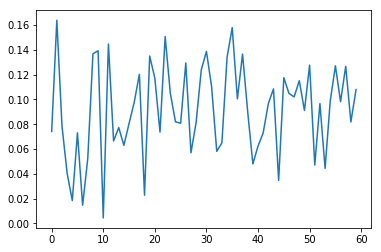

In [32]:
match_diff = np.absolute(match_noise-np.array(match_clean))
plt.plot(match_diff)
plt.show()

In [33]:
maxChange_ind = np.argsort(match_diff)[::-1]

In [34]:
np.array(words)[maxChange_ind]

array(['ant', 'glass', 'closet', 'bicycle', 'beetle', 'dress', 'bee',
       'hand', 'chimney', 'foot', 'cup', 'shirt', 'tomato', 'truck',
       'door', 'celery', 'pants', 'chisel', 'saw', 'dresser', 'leg',
       'window', 'coat', 'pliers', 'refrigerator', 'hammer', 'telephone',
       'train', 'cat', 'spoon', 'knife', 'screwdriver', 'horse', 'corn',
       'watch', 'dog', 'cow', 'carrot', 'apartment', 'butterfly',
       'airplane', 'church', 'key', 'barn', 'bottle', 'fly', 'car',
       'igloo', 'eye', 'desk', 'bed', 'house', 'skirt', 'table', 'arch',
       'lettuce', 'chair', 'arm', 'bear', 'bell'], dtype='<U12')

In [35]:
classAss[maxChange_ind]

array(['insect', 'kitchen', 'buildpart', 'vehicle', 'insect', 'clothing',
       'insect', 'bodypart', 'buildpart', 'bodypart', 'kitchen',
       'clothing', 'vegetable', 'vehicle', 'buildpart', 'vegetable',
       'clothing', 'tool', 'tool', 'furniture', 'bodypart', 'buildpart',
       'clothing', 'tool', 'manmade', 'tool', 'manmade', 'vehicle',
       'animal', 'kitchen', 'kitchen', 'tool', 'animal', 'vegetable',
       'manmade', 'animal', 'animal', 'vegetable', 'building', 'insect',
       'vehicle', 'building', 'manmade', 'building', 'kitchen', 'insect',
       'vehicle', 'building', 'bodypart', 'furniture', 'furniture',
       'building', 'clothing', 'furniture', 'buildpart', 'vegetable',
       'furniture', 'bodypart', 'animal', 'manmade'], dtype='<U9')

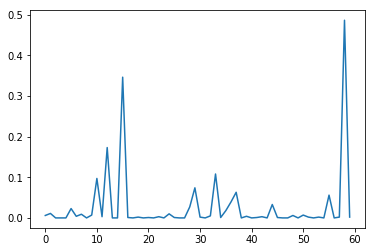

In [36]:
plt.plot(X[:,22][maxChange_ind])
plt.show()

In [218]:
feature_similarity_total=[]

In [240]:
# length of the fMRI images of the first subject
sb = 7
nVoxel = len(data[sb][0][0][0])

insula_coord = list(pd.read_excel('./insula_coord/insula_coord_'+str(sb+1)+'.xls'))

Y = np.zeros((nWord, nVoxel))
# Average same words and add noises to some certain region of the brain
for k in range(nWord):
    for m in range(nRep):
        Y[k] += data[sb][word_index[k][m]][0][0]
    Y[k] /= nRep
Ymean = np.mean(Y,axis=0)
Y-= Ymean

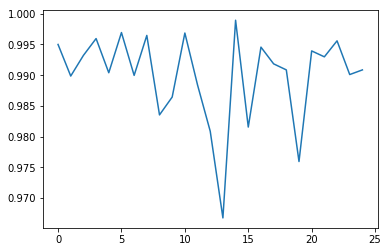

In [241]:
lamb = 0
# predict the clean fMRI images for each feature trained on 60 words
# W_clean = np.linalg.solve(X.T@X, X.T@Y)    
W_clean = np.linalg.solve(X.T@X + lamb*np.eye(nFeature), X.T@Y)

# predict the noisy fMRI images for each feature trained on 60 words
W_noisy = np.zeros((nFeature, nVoxel))
epoch = 1000
for i in range(epoch):
    
    Y_noise = np.copy(Y)
    for k in range(nWord):
        Y_noise[k][insula_coord] = 0.1*np.random.randn(len(insula_coord))    
    
    Xmean = np.mean(X,axis=0)
    Ymean_noise = np.mean(Y_noise,axis=0)
    # X_tr -= Xmean
    Y_noise -= Ymean_noise
    W_noisy += np.linalg.solve(X.T@X + lamb*np.eye(nFeature), X.T@Y_noise)
W_noisy/=epoch
    
ind = ind_Total[sb].astype(int)
feature_similarity = []
for k in range(nFeature):
    feature_similarity.append(cosine_similarity(W_clean[k][ind].reshape(1,-1), W_noisy[k][ind].reshape(1,-1))[0][0])

plt.plot(feature_similarity)
plt.show()

In [242]:
feature_similarity_total.append(np.array(feature_similarity))

In [268]:
feature_avg = np.mean(np.array(feature_similarity_total),axis=0)

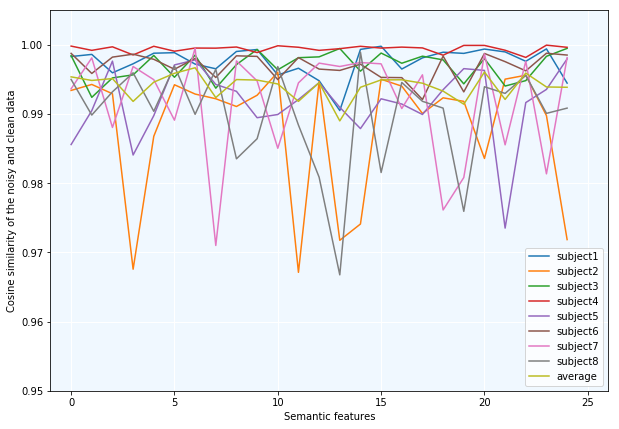

In [269]:
fig=plt.figure(figsize=(10, 7))

for i in range(8):
    plt.plot(feature_similarity_total[i], label='subject'+str(i+1))
plt.plot(feature_avg, label='average')

plt.xlabel('Semantic features')
plt.ylabel('Cosine similarity of the noisy and clean data')
plt.xlim((-1,26))
plt.ylim((0.95,1.005))
plt.legend(loc='lower right')
plt.grid(color='w', linestyle='-', linewidth=1)
ax = plt.gca()
ax.set_facecolor('#F0F8FF')

plt.show()
plt.show()

In [270]:
features=['approach','break','clean','drive','eat','enter' ,'fear','fill',\
          'hear','lift','listen','manipulate','move','near','open','push',\
          'ride','rub','run','say','see','smell','taste','touch','wear']
np.array(features)[np.argsort(feature_avg)]

array(['near', 'say', 'drive', 'manipulate', 'smell', 'fill', 'run',
       'open', 'wear', 'touch', 'listen', 'rub', 'move', 'eat', 'break',
       'lift', 'push', 'ride', 'hear', 'clean', 'approach', 'enter',
       'taste', 'see', 'fear'], dtype='<U10')

## 11. Training with Bootstrap on the noisey data

In [36]:
insula_coord_total=[]
for sb in range(8):
    insula_coord = list(pd.read_excel('./Insula_coord/Insula_coord/insula_coord_'+str(sb+1)+'.xls'))
    insula_coord_total.append(insula_coord)

In [37]:
def bootstrap_noisy(X, Y, count, count2, inds):
    Y_ps=[]
    # corr_mat = np.zeros((nWord, nWord))
    for k in range(0,nWord-1):
        for kk in range(k+1, nWord):
            ind = inds[count2]
            ind = np.array([[int(ele) for ele in ind]])
            X_tr = np.concatenate((X[0:k],X[k+1:kk],X[kk+1:]), axis = 0)
            Y_tr = np.concatenate((Y[0:k],Y[k+1:kk],Y[kk+1:]), axis = 0)

            mu_x = np.mean(X_tr, axis = 0)
            mu_y = np.mean(Y_tr, axis = 0)

            X_tr -= mu_x
            Y_tr -= mu_y
            X_va = X[[k, kk]] - mu_x
            Y_va = Y[[k, kk]] - mu_y
            W = np.linalg.solve(X_tr.T@X_tr + lamb*np.eye(nFeature), X_tr.T@Y_tr)
            
            Y_pred = X_va@W
            
            # calculate the cos-similarities
            coss11 = cosine_similarity(Y_pred[0][ind].reshape(1,-1), Y_va[0][ind].reshape(1,-1))
            coss22 = cosine_similarity(Y_pred[1][ind].reshape(1,-1), Y_va[1][ind].reshape(1,-1))
            coss12 = cosine_similarity(Y_pred[0][ind].reshape(1,-1), Y_va[1][ind].reshape(1,-1))
            coss21 = cosine_similarity(Y_pred[1][ind].reshape(1,-1), Y_va[0][ind].reshape(1,-1))
            
            # calculate the matches for comparing
            match1122 = coss11 + coss22
            match1221 = coss12 + coss21

            if match1122 > match1221: count += 1    
            count2 += 1
            
            # corr_mat[k][k] = coss11
            # corr_mat[kk][kk] = coss22
            # corr_mat[k][kk] = coss12
            # corr_mat[kk][k] = coss21
            
        Y_ps.append(Y_pred[0])
    # return Y_ps, count, count2, corr_mat
    return Y_ps, count, count2

In [38]:
def compute_noisy(i):
    insula_coord = insula_coord_total[i]
    nVoxel = len(data[i][0][0][0])
    Y = np.zeros((nWord, nVoxel)) # 60 images for training
    count = 0
    # Average same words
    for k in range(nWord):
        for m in range(nRep):
            Y[k] += data[i][word_index[k][m]][0][0]
        Y[k] /= nRep
        Y[k][insula_coord] = 0.1*np.random.randn(len(insula_coord))

    count2 = 0
    # select 500 voxels which perform best
    inds = np.array(pd.read_csv('./fMRI_data/ind'+str(i+1)+'.txt', header=None))
    
    # Begin bootstrap
    Y_ps, count, count2 = bootstrap_noisy(X, Y, count, count2, inds)  
    Y_preds.append(Y_ps)
    
    # write corr_mat into file
    # pickle.dump(corr_mat,open('corr_mat_'+str(i+1)+'.txt', 'wb') ) 
    print(i, count/count2)

In [40]:
lamb = 1.5
Y_preds = []

print('Parent process %s.' % os.getpid())

p = Pool(8)
for i in range(8):  
    p.apply_async(compute_noisy, args=(i,))
p.close()
p.join()

print('All subprocesses done.')

Parent process 24214.
6 0.7203389830508474
2 0.751412429378531
7 0.6124293785310735
4 0.7135593220338983
5 0.6209039548022599
3 0.7367231638418079
1 0.8141242937853107
0 0.8141242937853107
All subprocesses done.


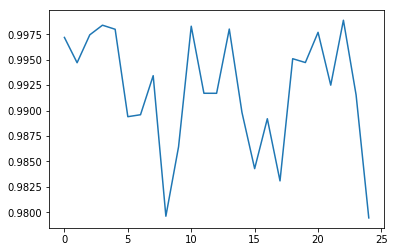

In [144]:
# predict the noisy fMRI images for each feature trained on 60 words
# with randomly chosen voxels
rand_coord = np.random.randint(nVoxel, size=len(insula_coord))
W_noisy = np.zeros((nFeature, nVoxel))
epoch = 1000
for i in range(epoch):
    
    Y_noise = np.copy(Y)
    for k in range(nWord):
        Y_noise[k][rand_coord] = 0.1*np.random.randn(len(insula_coord))    
    
    Xmean = np.mean(X,axis=0)
    Ymean_noise = np.mean(Y_noise,axis=0)
    # X_tr -= Xmean
    Y_noise -= Ymean_noise
    W_noisy += np.linalg.solve(X.T@X, X.T@Y_noise)
W_noisy/=epoch
    
ind = ind_Total[7].astype(int)
feature_similarity = []
for k in range(nFeature):
    feature_similarity.append(cosine_similarity(W_clean[k][ind].reshape(1,-1), W_noisy[k][ind].reshape(1,-1))[0][0])

plt.plot(feature_similarity)
plt.show()

In [145]:
np.array(features)[np.argsort(feature_similarity)]

array(['wear', 'hear', 'rub', 'push', 'lift', 'ride', 'enter', 'fear',
       'open', 'touch', 'move', 'manipulate', 'smell', 'fill', 'break',
       'say', 'run', 'approach', 'clean', 'see', 'eat', 'near', 'listen',
       'drive', 'taste'], dtype='<U10')